In [342]:
import sys
sys.path.append("C:\\WorkingGround\\02450 Introduction to Machine Learning and Data Mining E17\\02450Toolbox_Python\Tools")
sys.path

['',
 'C:\\WorkingGround\\Anaconda\\envs\\ipykernel_py3\\python36.zip',
 'C:\\WorkingGround\\Anaconda\\envs\\ipykernel_py3\\DLLs',
 'C:\\WorkingGround\\Anaconda\\envs\\ipykernel_py3\\lib',
 'C:\\WorkingGround\\Anaconda\\envs\\ipykernel_py3',
 'C:\\WorkingGround\\Anaconda\\envs\\ipykernel_py3\\lib\\site-packages',
 'C:\\WorkingGround\\Anaconda\\envs\\ipykernel_py3\\lib\\site-packages\\cycler-0.10.0-py3.6.egg',
 'C:\\WorkingGround\\Anaconda\\envs\\ipykernel_py3\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\houxi\\.ipython',
 'C:\\WorkingGround\\02450 Introduction to Machine Learning and Data Mining E17\\02450Toolbox_Python\\Tools',
 'C:\\WorkingGround\\02450 Introduction to Machine Learning and Data Mining E17\\02450Toolbox_Python\\Tools',
 'C:\\WorkingGround\\02450 Introduction to Machine Learning and Data Mining E17\\02450Toolbox_Python\\Tools',
 'C:\\WorkingGround\\02450 Introduction to Machine Learning and Data Mining E17\\02450Toolbox_Python\\Tools',
 'C:\\WorkingGround\\0

In [343]:
import sqlite3
import pandas as pd
from sklearn import tree
from sklearn import metrics
from sklearn.cross_validation import KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
from sklearn.mixture import GMM
from sklearn.mixture import GaussianMixture
from sklearn import model_selection
from sklearn import decomposition

from toolbox_02450 import clusterplot

from collections import defaultdict
from scipy import stats

from matplotlib.pyplot import figure, plot, legend, xlabel, show,annotate
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import plotly.plotly as py
from plotly.graph_objs import *
import plotly.graph_objs as go
%matplotlib inline

In [344]:
#data = np.loadtxt('dataset.csv', skiprows=1, delimiter=',')
df_match = pd.read_csv('dataset.csv')
print ("All columns ", df_match.columns.values)

All columns  ['stage' 'home_team_goal' 'away_team_goal' 'possession_home' 'B365H'
 'B365D' 'B365A' 'BWH' 'BWD' 'BWA' 'IWH' 'IWD' 'IWA' 'LBH' 'LBD' 'LBA'
 'WHH' 'WHD' 'WHA' 'VCH' 'VCD' 'VCA' 'team_fifa_api_id_home'
 'buildUpPlaySpeed_home' 'buildUpPlayDribbling_home'
 'buildUpPlayPassing_home' 'buildUpPlayPositioningClass_home_isOrganised'
 'chanceCreationPassing_home' 'chanceCreationCrossing_home'
 'chanceCreationShooting_home'
 'chanceCreationPositioningClass_home_isOrganised' 'defencePressure_home'
 'defenceAggression_home' 'defenceTeamWidth_home' 'team_fifa_api_id_away'
 'buildUpPlaySpeed_away' 'buildUpPlayDribbling_away'
 'buildUpPlayPassing_away' 'buildUpPlayPositioningClass_away_isOrganised'
 'chanceCreationPassing_away' 'chanceCreationCrossing_away'
 'chanceCreationShooting_away'
 'chanceCreationPositioningClass_away_isOrganised' 'defencePressure_away'
 'defenceAggression_away' 'defenceTeamWidth_away' 'corner_home'
 'corner_away' 'cross_home' 'cross_away' 'throwin_home' 'throwin

In [345]:
home_wins = np.array((df_match['home_team_goal'] > df_match['away_team_goal']).tolist())
draws = np.array((df_match['home_team_goal'] == df_match['away_team_goal']).tolist())
match_results=list()
match_results_dict=dict()
for i ,match in enumerate(home_wins):
    if match:
        match_results.append(0)   ## home team win 
    elif draws[i]:
        match_results.append(1)   ## draw 
    else:
        match_results.append(2)  ## home team lose 

match_results_dict[0]='Home'
match_results_dict[1]='Draw'
match_results_dict[2]='Away'
df_match['Result']=match_results

In [346]:
pregame_features = ['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD',
                    'IWA', 'LBH', 'LBD', 'LBA', 'WHH', 'WHD', 'WHA', 'VCH', 'VCD', 'VCA', 'buildUpPlaySpeed_home',
                    'buildUpPlayDribbling_home', 'buildUpPlayPassing_home',
                    'buildUpPlayPositioningClass_home_isOrganised', 'chanceCreationPassing_home',
                    'chanceCreationCrossing_home', 'chanceCreationShooting_home',
                    'chanceCreationPositioningClass_home_isOrganised', 'defencePressure_home', 
                    'defenceAggression_home', 'defenceTeamWidth_home', 'buildUpPlaySpeed_away',
                    'buildUpPlayDribbling_away', 'buildUpPlayPassing_away', 
                    'buildUpPlayPositioningClass_away_isOrganised', 'chanceCreationPassing_away',
                    'chanceCreationCrossing_away', 'chanceCreationShooting_away', 
                    'chanceCreationPositioningClass_away_isOrganised', 'defencePressure_away',
                    'defenceAggression_away', 'defenceTeamWidth_away']


postgame_features = ['possession_home', 'corner_home', 
                    'corner_away', 'cross_home', 'cross_away', 'throwin_home', 'throwin_away',
                    'shoton_home', 'shoton_away', 'shotoff_home', 'shotoff_away', 'foulcommit_home', 
                    'foulcommit_away', 'ycard_home', 'ycard_away', 'rcard_home', 'rcard_away']

In [347]:
X=df_match[pregame_features]

y=df_match['Result']
print ("Using in game statistics to cluster match results ")

Using in game statistics to cluster match results 


In [348]:
X_st=(X - X.mean()) / X.std()

### 1. Cluster Data by GMM and use cross-validation to estimate the number of components in the GMM. Interpret the extracted cluster centers

In [349]:
pca = decomposition.PCA(n_components=2)
pca.fit(X_st)
##Fit in game observations to 2D for visualization
X_pcaed = pca.transform(X_st)

d = {'PC1': X_pcaed[:,0], 'PC2': X_pcaed[:,1], 'Result':df_match['Result'].values}
df_pcaed=pd.DataFrame(data=d)

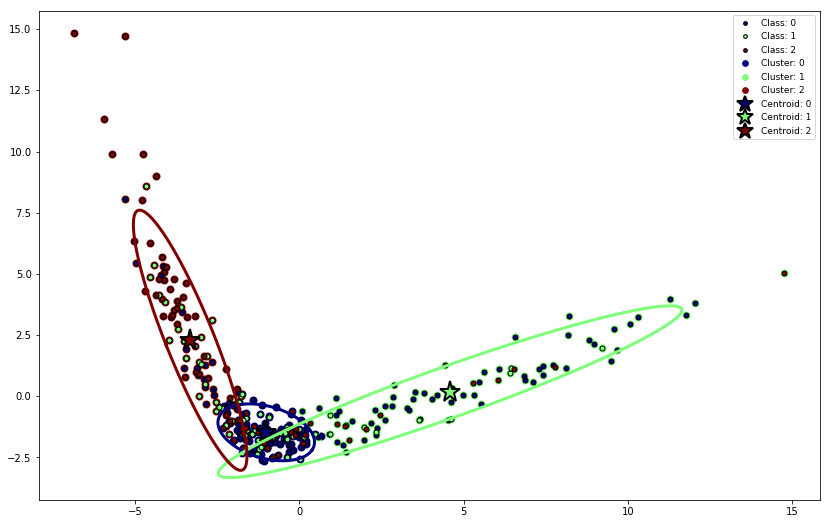

37.7768491433


In [359]:
N, M = X_st.shape
# Number of clusters
K = 3
cov_type = 'diag'       
# type of covariance, you can try out 'diag' as well
reps = 1        
mean_matches_pre=list()
# number of fits with different initalizations, best result will be kept
# Fit Gaussian mixture model
gmm = GaussianMixture(n_components=K, covariance_type=cov_type, n_init=reps).fit(X_st)
cls = gmm.predict(X_st)    
df_pcaed['CLUSTERPRE']=cls
# extract cluster labels
cds = gmm.means_      
mean_matches_pre.append(cds)
cds_pca = pca.transform(cds)
# extract cluster centroids (means of gaussians)
covs = gmm.covariances_

pca_covs_list=list()
for label in sorted(df_pcaed.CLUSTERPRE.unique()):
    two_pcs_covs=np.cov(df_pcaed[df_pcaed['CLUSTERPRE']==label][['PC1','PC2']].as_matrix().T)
    pca_covs_list.append(two_pcs_covs)
    
covs=np.array(pca_covs_list)


# Plot results:
figure(figsize=(14,9))
df_test=df_pcaed.sample(n=300)
clusterplot(df_test[['PC1','PC2']], clusterid=df_test['CLUSTERPRE'], centroids=cds_pca, y=df_test['Result'], covars=covs)
show()
print (np.mean(df_pcaed['CLUSTERPRE'] == df_pcaed['Result']) * 100)

In [312]:
mean_matches_df = pd.DataFrame(columns=pregame_features,data=mean_matches_pre[0])
mean_matches_df.head()

,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,...,buildUpPlayDribbling_away,buildUpPlayPassing_away,buildUpPlayPositioningClass_away_isOrganised,chanceCreationPassing_away,chanceCreationCrossing_away,chanceCreationShooting_away,chanceCreationPositioningClass_away_isOrganised,defencePressure_away,defenceAggression_away,defenceTeamWidth_away
0,-0.775420,1.065943,1.232857,-0.795132,1.067697,1.256602,-0.813454,1.080990,1.248551,-0.796773,...,-0.108872,0.276392,0.219459,0.203325,0.113209,-0.055073,0.251354,-0.112712,-0.021218,-0.051603
1,-0.282252,-0.559994,-0.338983,-0.273833,-0.571498,-0.331975,-0.260342,-0.553913,-0.330290,-0.276606,...,-0.081887,0.170339,0.119258,0.112292,0.069213,-0.055258,0.167201,-0.078333,-0.013425,-0.036128
2,1.330348,-0.219414,-0.777836,1.337694,-0.201809,-0.815797,1.334903,-0.246254,-0.809821,1.344204,...,0.258525,-0.592574,-0.443360,-0.413824,-0.241771,0.154263,-0.559762,0.256707,0.046083,0.117978


In [314]:
mean_matches_df.T.to_csv('N_transposed.csv')

Fitting model for K=1 with Covs Matrix full
Fitting model for K=2 with Covs Matrix full
Fitting model for K=3 with Covs Matrix full
Fitting model for K=4 with Covs Matrix full
Fitting model for K=5 with Covs Matrix full
Fitting model for K=6 with Covs Matrix full
Fitting model for K=7 with Covs Matrix full
Fitting model for K=8 with Covs Matrix full
Fitting model for K=9 with Covs Matrix full
Fitting model for K=10 with Covs Matrix full


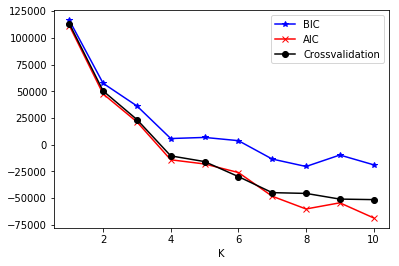

BIC, AIC TEST


In [333]:

N, M = X.shape

# Range of K's to try
KRange = range(1,11)
T = len(KRange)

cv_type = 'full'
reps = 3                # number of fits with different initalizations, best result will be kept

# Allocate variables
BIC = np.zeros((T,))
AIC = np.zeros((T,))
CVE = np.zeros((T,))

# K-fold crossvalidation
CV = model_selection.KFold(n_splits=10,shuffle=True)

model_dicts=defaultdict(dict)
#for cv_type in cv_types:
for t,K in enumerate(KRange):
            print('Fitting model for K={0} with Covs Matrix {1}'.format(K, cv_type))

            # Fit Gaussian mixture model
            gmm = GaussianMixture(n_components=K, covariance_type=cv_type, n_init=reps).fit(X_st)

            # Get BIC and AIC
            BIC[t,] = gmm.bic(X_st)
            AIC[t,] = gmm.aic(X_st)

            # For each crossvalidation fold
            for train_index, test_index in CV.split(X_st):

                # extract training and test set for current CV fold
                X_train = X_st.iloc[train_index]
                X_test = X_st.iloc[test_index]

                # Fit Gaussian mixture model to X_train
                gmm = GaussianMixture(n_components=K, covariance_type=cv_type, n_init=reps).fit(X_train)

                # compute negative log likelihood of X_test
                CVE[t] += -gmm.score_samples(X_test).sum()

    
# Plot results

figure(1); 
plot(KRange, BIC,'-*b')
plot(KRange, AIC,'-xr')
plot(KRange, 2*CVE,'-ok')
legend(['BIC', 'AIC', 'Crossvalidation'])
xlabel('K')
show()
print('BIC, AIC TEST')